Req

In [3]:
import re
import unicodedata
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import textstat
import os

from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm

from textblob import TextBlob
from textblob_nl import PatternAnalyzer

warnings.filterwarnings("ignore")

# set language to dutch 
textstat.set_lang("nl")

# progress bar when apply functions to dataframe
tqdm.pandas()

# better quality plots
%config InlineBackend.figure_format = "retina"

# Title font size
TITLE_SIZE = 14

# Datasets inladen

In [18]:
import pandas as pd

# Corrected file paths (replace with your actual local paths)
ev_sales_path = "D:\dataset_with_months.csv"
sentiment_path = "D:/sentiment_analysis_results.csv"

# Load datasets
df_ev_sales = pd.read_csv(ev_sales_path, low_memory=False)
df_sentiment = pd.read_csv(sentiment_path, low_memory=False)

# Display first few rows
df_ev_sales.head(), df_sentiment.head()




(  Kenteken                       Voertuigsoort         Merk  \
 0   TFX83D  Motorrijtuig met beperkte snelheid  NEW HOLLAND   
 1   TFX83G  Motorrijtuig met beperkte snelheid        LINDE   
 2   TFX83L             Land- of bosbouwtrekker        CLAAS   
 3   TFX83T             Land- of bosbouwtrekker          JCB   
 4   TFX84N             Land- of bosbouwtrekker   JOHN DEERE   
 
   Datum eerste toelating Brandstof omschrijving  CO2 uitstoot gecombineerd  \
 0             2011-06-30                 Diesel                        NaN   
 1             2019-06-30          Elektriciteit                        NaN   
 2             2014-06-30                 Diesel                        NaN   
 3             2021-04-25                 Diesel                        NaN   
 4             2013-06-30                 Diesel                        NaN   
 
    Max vermogen 60 minuten  Netto max vermogen elektrisch  \
 0                      NaN                            NaN   
 1            

#  Assign Years & Aggregate Sentiment Data

In [19]:
# Adjust the year range based on actual sentiment data (2015-2023)
start_year = 2015  # Sentiment data starts at 2015
end_year = 2023
num_years = end_year - start_year + 1

# Distribute sentiment data evenly from 2015 onward
years = np.linspace(start_year, end_year, num=len(df_sentiment), dtype=int)
df_sentiment['Year'] = years

# Recalculate yearly sentiment scores
df_sentiment_yearly = df_sentiment.groupby('Year')['sentiment_score'].mean().reset_index()

# Merge with EV sales data again
df_merged = pd.merge(df_ev_sales, df_sentiment_yearly, on='Year', how='left')

# Display the corrected merged dataset
print(df_merged.head(10))  # Check first few rows for accuracy


  Kenteken                       Voertuigsoort         Merk  \
0   TFX83D  Motorrijtuig met beperkte snelheid  NEW HOLLAND   
1   TFX83G  Motorrijtuig met beperkte snelheid        LINDE   
2   TFX83L             Land- of bosbouwtrekker        CLAAS   
3   TFX83T             Land- of bosbouwtrekker          JCB   
4   TFX84N             Land- of bosbouwtrekker   JOHN DEERE   
5   TFX85N  Motorrijtuig met beperkte snelheid        ATLAS   
6   TFX85S             Land- of bosbouwtrekker   JOHN DEERE   
7   TFX85T  Motorrijtuig met beperkte snelheid          JCB   
8   TFX85X             Land- of bosbouwtrekker   ARCTIC CAT   
9   TFX86B             Land- of bosbouwtrekker        FENDT   

  Datum eerste toelating Brandstof omschrijving  CO2 uitstoot gecombineerd  \
0             2011-06-30                 Diesel                        NaN   
1             2019-06-30          Elektriciteit                        NaN   
2             2014-06-30                 Diesel                        N

In [21]:
# Step 1: Filter EV Sales Data for Only Electric Vehicles
df_ev_sales = df_ev_sales[df_ev_sales['Brandstof omschrijving'] == 'Elektriciteit']

# Step 2: Aggregate EV Sales by Year-Month (Counting Number of EVs Sold per Month)
df_ev_sales['Year-Month'] = pd.to_datetime(df_ev_sales['Year-Month'])
ev_sales_monthly = df_ev_sales.groupby('Year-Month').size().reset_index(name='EV_Sales')

# Display the processed EV sales dataset
ev_sales_monthly.head()

,Year-Month,EV_Sales
0,2010-01-01,376
1,2011-01-01,510
2,2012-01-01,604
3,2013-01-01,776
4,2014-01-01,1148


Train xgboost

Mean Absolute Error (MAE): 10599.42


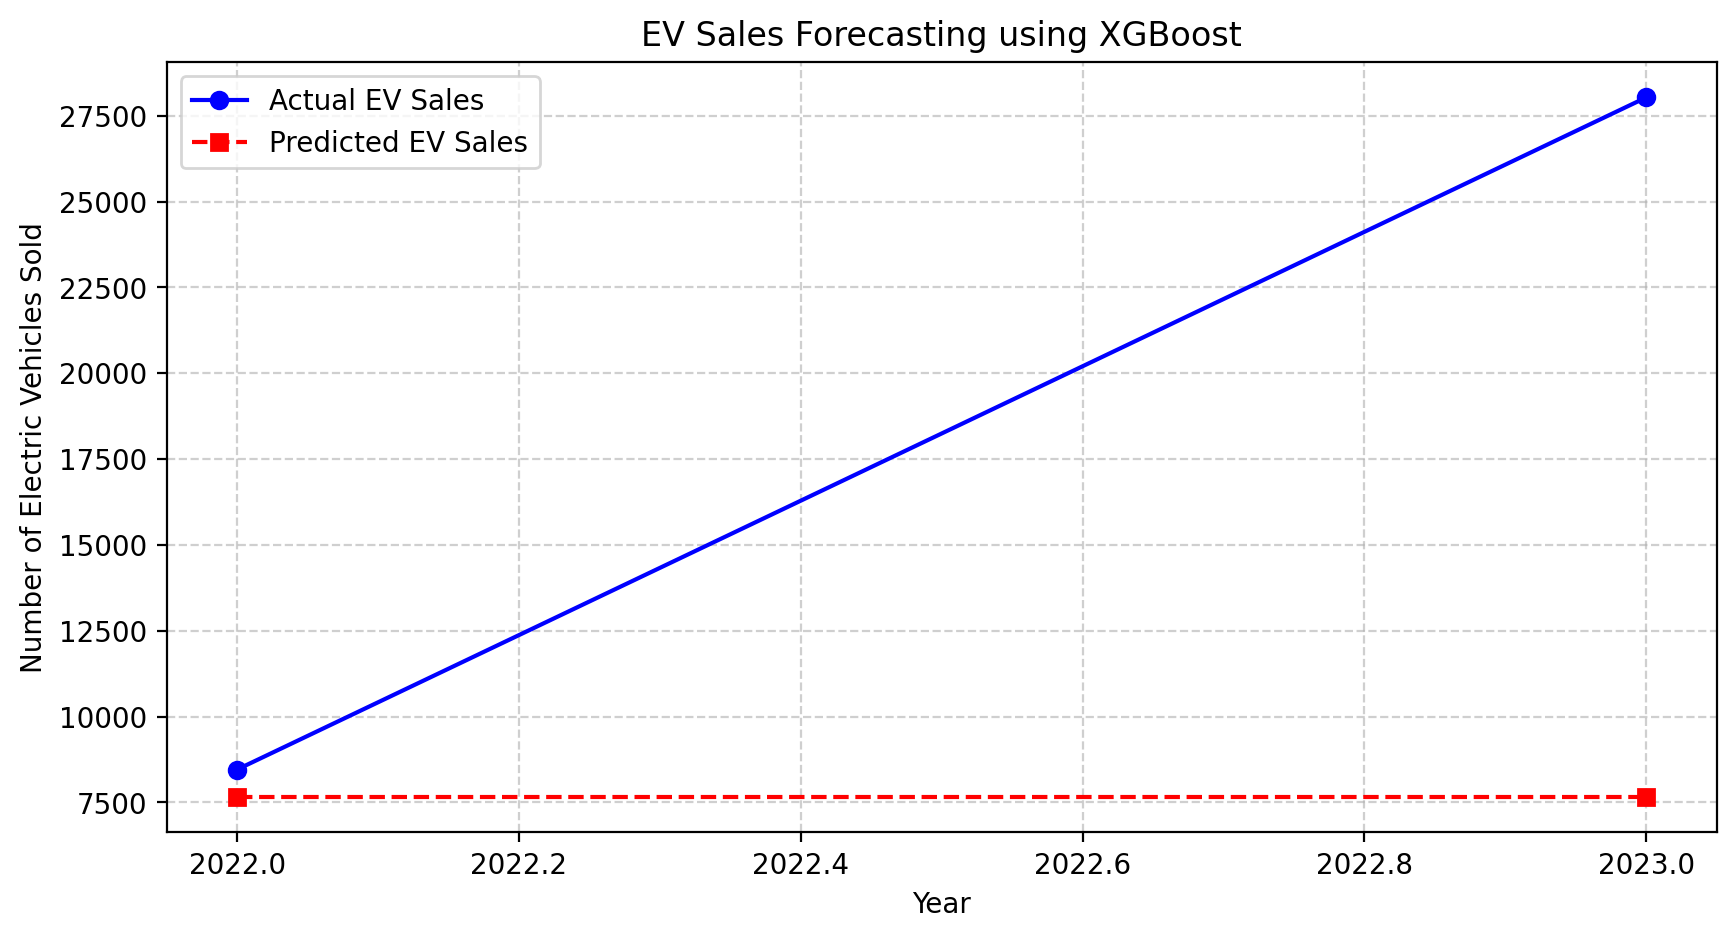

In [22]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Assign Years to Sentiment Data (Evenly distribute across 2015-2023)
start_year = 2015
end_year = 2023
num_years = end_year - start_year + 1

# Evenly distribute sentiment articles across 2015-2023
years = np.linspace(start_year, end_year, num=len(df_sentiment), dtype=int)
df_sentiment['Year'] = years

# Aggregate sentiment scores per year (calculate yearly average sentiment score)
df_sentiment_yearly = df_sentiment.groupby('Year')['sentiment_score'].mean().reset_index()

# Step 2: Aggregate EV Sales Data by Year (Summing Monthly EV Sales)
ev_sales_yearly = ev_sales_monthly.copy()
ev_sales_yearly['Year'] = ev_sales_yearly['Year-Month'].dt.year  # Extract year
ev_sales_yearly = ev_sales_yearly.groupby('Year')['EV_Sales'].sum().reset_index()

# Step 3: Merge EV Sales and Sentiment Data
df_merged = pd.merge(ev_sales_yearly, df_sentiment_yearly, on='Year', how='left')

# Step 4: Create Lag Features for Time Series Forecasting
def create_lag_features(df, lag_years=5):
    df_lagged = df.copy()
    for lag in range(1, lag_years + 1):
        df_lagged[f'ev_sales_lag{lag}'] = df_lagged['EV_Sales'].shift(lag)
        df_lagged[f'sentiment_lag{lag}'] = df_lagged['sentiment_score'].shift(lag)
    df_lagged.dropna(inplace=True)  # Remove rows with NaN due to shifting
    return df_lagged

df_supervised = create_lag_features(df_merged, lag_years=5)

# Step 5: Define Train and Test Sets (Using 2023 as the last available year)
train = df_supervised[df_supervised['Year'] < 2022]
test = df_supervised[df_supervised['Year'] >= 2022]

# Define features and target variable
features = [col for col in df_supervised.columns if 'lag' in col]  # Use lagged features
X_train, y_train = train[features], train['EV_Sales']
X_test, y_test = test[features], test['EV_Sales']

# Step 6: Train XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Step 7: Make Predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Step 9: Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(test['Year'], y_test, label='Actual EV Sales', marker='o', color='blue')
plt.plot(test['Year'], y_pred, label='Predicted EV Sales', marker='s', linestyle='dashed', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Electric Vehicles Sold')
plt.legend()
plt.title('EV Sales Forecasting using XGBoost')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
